# Recurrent Neural Networks

## Univariate Time Series Regression

## Imports

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras

Using TensorFlow backend.


In [287]:
sns.set_style('whitegrid')
np.random.seed(42)

## Get Data

In [211]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2019').dropna()
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2010-01-04 to 2018-12-31
Data columns (total 1 columns):
SP500    2264 non-null float64
dtypes: float64(1)
memory usage: 35.4 KB


## Preprocessing

In [212]:
sp500_scaled = sp500.apply(minmax_scale)
sp500_scaled.describe()

,SP500
count,2264.000000
mean,0.437175
std,0.272843
min,0.000000
25%,0.172811
50%,0.462480
75%,0.600596
max,1.000000


In [89]:
y.shape

(2201, 1)

## Generating recurrent sequences from our time series

Our time series is a sequence of numbers indexed by time:

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from as animated below.

<img src="images/timeseries_windowing.gif" width=600 height=600/>

A window of size S = 5 (as illustrated above) produces input/output pairs like those in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline  {\langle x_1,x_2,x_3,x_4,x_5\rangle} & { x_6} \\
\ {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & {x_{7} } \\
  {\vdots} & {\vdots}\\
 { \langle x_{T-5},x_{T-4},x_{T-3},x_{T-2},x_{T-1} \rangle } &  {x_{T}}
\end{array}$$

Generally speaking, for window size S, the relationship takes the form 

$$x_t = f( x_{t-1}, x_{t-2}, ..., x_{t-S}) \quad\forall t=S, S+1, ..., T$$

Each of the $T-S$ lagged input sequence or vector is of length S with a corresponding scalar output.

In [9]:
def create_univariate_rnn_data(data, window_size):
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    n = data.shape[0]
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [82]:
window_size = 63

In [83]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [85]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2010-04-06,0.057862,0.059712,0.060037,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,...,0.075061,0.079443,0.076062,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397
2010-04-07,0.059712,0.060037,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,...,0.079443,0.076062,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445
2010-04-08,0.060037,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,0.060508,...,0.076062,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445,0.083782
2010-04-09,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,0.060508,0.049209,...,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445,0.083782,0.085873
2010-04-12,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,0.060508,0.049209,0.036255,...,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445,0.083782,0.085873,0.090029


In [86]:
y.head()

,SP500
DATE,
2010-04-06,0.087445
2010-04-07,0.083782
2010-04-08,0.085873
2010-04-09,0.090029
2010-04-12,0.091134


In [87]:
X.shape

(2201, 63)

In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2010-04-06 to 2018-12-31
Data columns (total 63 columns):
0     2201 non-null float64
1     2201 non-null float64
2     2201 non-null float64
3     2201 non-null float64
4     2201 non-null float64
5     2201 non-null float64
6     2201 non-null float64
7     2201 non-null float64
8     2201 non-null float64
9     2201 non-null float64
10    2201 non-null float64
11    2201 non-null float64
12    2201 non-null float64
13    2201 non-null float64
14    2201 non-null float64
15    2201 non-null float64
16    2201 non-null float64
17    2201 non-null float64
18    2201 non-null float64
19    2201 non-null float64
20    2201 non-null float64
21    2201 non-null float64
22    2201 non-null float64
23    2201 non-null float64
24    2201 non-null float64
25    2201 non-null float64
26    2201 non-null float64
27    2201 non-null float64
28    2201 non-null float64
29    2201 non-null float64
30    2201 non-null float64
31    2

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

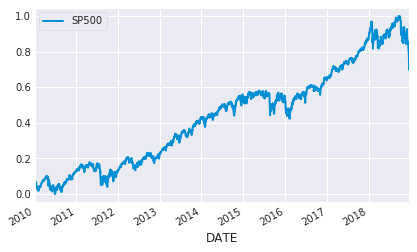

In [214]:
sp500_scaled.plot(lw=2);

In [90]:
X_train = X[:'2017'].values.reshape(-1, window_size, 1)
y_train = y[:'2017']

# keep the last year for testing
X_test = X['2018'].values.reshape(-1, window_size, 1)
y_test = y['2018']

In [91]:
n_obs, window_size, n_features = X_train.shape

In [92]:
y_train.shape

(1950, 1)

## Keras LSTM Layer

In [ ]:
LSTM(units, 
      activation='tanh', 
      recurrent_activation='hard_sigmoid', 
      use_bias=True,
      kernel_initializer='glorot_uniform', 
      recurrent_initializer='orthogonal', 
      bias_initializer='zeros',
      unit_forget_bias=True, 
      kernel_regularizer=None, 
      recurrent_regularizer=None, 
      bias_regularizer=None,
      activity_regularizer=None, 
      kernel_constraint=None, 
      recurrent_constraint=None, 
      bias_constraint=None,
      dropout=0.0, 
      recurrent_dropout=0.0, 
      implementation=1, 
      return_sequences=False, 
      return_state=False,
      go_backwards=False, 
      stateful=False, 
      unroll=False)

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [252]:
rnn = Sequential([
    LSTM(units=20, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [253]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 20)                1760      
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [254]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [255]:
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

In [97]:
rnn_path = 'models/sp500.lstm5.weights.best.hdf5'
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True,
                              period=5)

In [98]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=25,
                              restore_best_weights=True)

In [99]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=500,
                 batch_size=20,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpointer, early_stopping],
                 verbose=1)

Train on 1950 samples, validate on 251 samples
Epoch 1/500
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0130 - val_loss: 0.0056
Epoch 2/500
1950/1950 [==============================] - 4s 2ms/step - loss: 6.3845e-04 - val_loss: 0.0032
Epoch 3/500
1950/1950 [==============================] - 4s 2ms/step - loss: 4.8971e-04 - val_loss: 0.0021
Epoch 4/500
1950/1950 [==============================] - 4s 2ms/step - loss: 4.2012e-04 - val_loss: 0.0019
Epoch 5/500
1950/1950 [==============================] - 4s 2ms/step - loss: 3.5866e-04 - val_loss: 9.3148e-04
Epoch 6/500
1950/1950 [==============================] - 4s 2ms/step - loss: 3.1000e-04 - val_loss: 6.9891e-04
Epoch 7/500
1950/1950 [==============================] - 4s 2ms/step - loss: 2.9308e-04 - val_loss: 6.9391e-04
Epoch 8/500
1950/1950 [==============================] - 4s 2ms/step - loss: 2.6161e-04 - val_loss: 7.1533e-04
Epoch 9/500
1950/1950 [==============================] - 4s 2ms/step - loss: 2.4278e-

In [256]:
rnn.load_weights(rnn_path)

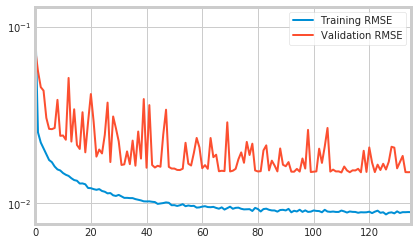

In [288]:
loss_history = pd.DataFrame(result.history).pow(.5)
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.plot(logy=True, lw=2);

## Evaluate model performance

In [215]:
def eval_result():
    test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)
    train_predict = pd.Series(rnn.predict(X_train).squeeze(), index=y_train.index)
    rmse = np.sqrt(mean_squared_error(test_predict, y_test))
    return test_predict, train_predict, rmse

In [216]:
test_predict, train_predict, rmse = eval_result()

In [217]:
predictions = (test_predict.to_frame('prediction').assign(data='test')
               .append(train_predict.to_frame('prediction').assign(data='train')))
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2018-01-02 to 2017-12-29
Data columns (total 2 columns):
prediction    2201 non-null float32
data          2201 non-null object
dtypes: float32(1), object(1)
memory usage: 43.0+ KB


In [219]:
results = sp500_scaled.join(predictions).dropna()
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2010-04-06 to 2018-12-31
Data columns (total 3 columns):
SP500         2201 non-null float64
prediction    2201 non-null float32
data          2201 non-null object
dtypes: float32(1), float64(1), object(1)
memory usage: 60.2+ KB


In [225]:
corr = {}
for run, df in results.groupby('data'):
    corr[run] = df.SP500.corr(df.prediction)

In [266]:
sp500_scaled['Train Prediction'] = pd.Series(train_predict.squeeze(), index=y_train.index)
sp500_scaled['Test Prediction'] = pd.Series(test_predict.squeeze(), index=y_test.index)

In [268]:
training_error = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
testing_error = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print('Training Error: {:.4f} | Test Error: {:.4f}'.format(training_error, testing_error))

Training Error: 0.0078 | Test Error: 0.0150


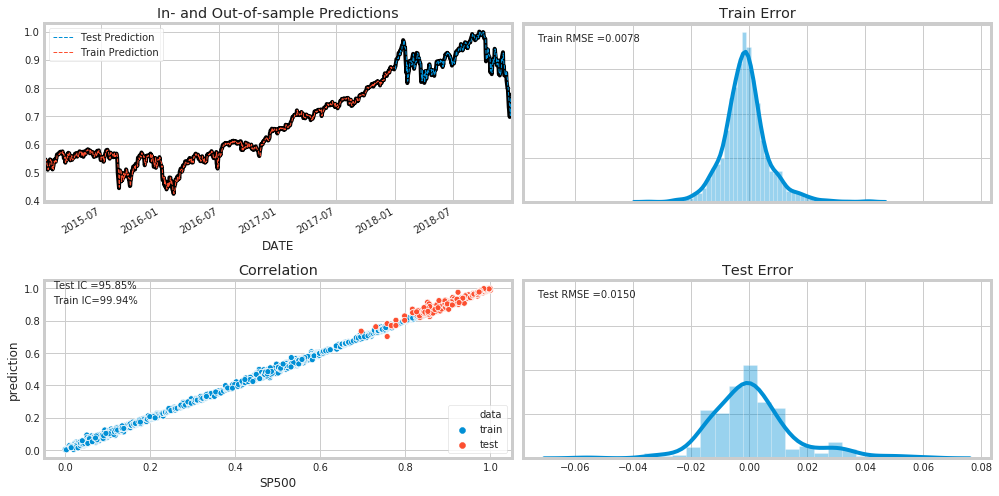

In [286]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)

sp500_scaled.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500_scaled.loc['2015':, ['Test Prediction', 'Train Prediction']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

sns.scatterplot(x='SP500', y='prediction', data=results, hue='data', ax=ax3)
ax3.text(x=.02, y=.95, s='Test IC ={:.2%}'.format(corr['test']), transform=ax3.transAxes)
ax3.text(x=.02, y=.87, s='Train IC={:.2%}'.format(corr['train']), transform=ax3.transAxes)
ax3.set_title('Correlation')
ax3.legend(loc='lower right')

sns.distplot(train_predict.squeeze()-y_train.squeeze(), ax=ax2)
ax2.set_title('Train Error')
ax2.text(x=.03, y=.9, s='Train RMSE ={:.4f}'.format(training_error), transform=ax2.transAxes)
sns.distplot(test_predict.squeeze()-y_test.squeeze(), ax=ax4)
ax4.set_title('Test Error')
ax4.text(x=.03, y=.9, s='Test RMSE ={:.4f}'.format(testing_error), transform=ax4.transAxes)

fig.tight_layout()
fig.savefig('images/rnn_sp500_regression', dpi=300);